In [10]:
import sys
import importlib
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

import torch
import h5py

##### Read HDF5 file

In [2]:
def print_attrs(name, obj):
    """Print attributes of a group or dataset"""
    print(f"\nAttributes for group '{name}':")
    print("-" * 40)
    for key, value in obj.attrs.items():
        print(f"{key}: {value}")

def print_structure(name, obj):
        """Print the structure of groups and datasets"""
        if isinstance(obj, h5py.Group):
            print(f"\nGroup: {name}")
            print_attrs(name, obj)
        elif isinstance(obj, h5py.Dataset):
            print(f"\nDataset: {name}")
            print(f"    Shape: {obj.shape}")
            print(f"    Type: {obj.dtype}")
            print_attrs(name, obj)

def print_group_structure(group, indent=0):
    """Recursively print group structure"""
    
    for key, item in group.items():
        print("  " * indent + f"├── {key}")
        if isinstance(item, h5py.Group):
            print_group_structure(item, indent + 1)
        elif isinstance(item, h5py.Dataset):
            print("  " * (indent + 1) + f"└── Shape: {item.shape}, Type: {item.dtype}")

def read_multiple_items_subgroup(file, subgroup_path):
    data_list = []
    items = list(   file[subgroup_path].keys())
    for item in items:
        data = file[subgroup_path][item][()]
        data_list.append(data)
    return data_list


In [3]:
path = './ALICE/K-2/96x96/batch-1/datapoints.h5' #
path = './ALICE/n5e5-N-3_S-2/96x96/96x96/batch-1/datapoints.h5' # 1461784866
# path =  './datasets/N-2_S-1/256x256/batch-6/datapoints.h5' # 6548158133
group_name = '1461784866'

try:
    with h5py.File(path, 'r') as f:
        main_group = f[group_name]
        print(f"Group: {main_group}")
        print_group_structure(main_group)
        print_attrs(group_name, main_group)
   
        # Group values
        group_paths = {k: f'{group_name}/{k}' for k in main_group.keys()}
        C_DD = f[group_paths['C_DD']]['data'][()]
        C_DG = f[group_paths['C_DG']]['data'][()]
        device = f[group_paths['device']]['data'][()]
        sensors_coordinates = f[group_paths['sensors_coordinates']]['data'][()]
        x_vol = f[group_paths['x_vol']]['data'][()]
        y_vol = f[group_paths['y_vol']]['data'][()]
        
        cuts = read_multiple_items_subgroup(f, group_paths['cuts'])
        csd = read_multiple_items_subgroup(f, group_paths['csd'])
        sensor_output = read_multiple_items_subgroup(f, group_paths['sensor_output'])
        csd_gradient = read_multiple_items_subgroup(f, group_paths['csd_gradient'])


        # Attributes
        config_tuple = (main_group.attrs['K'],
                        main_group.attrs['N'],
                        main_group.attrs['S'])
        
        p_dd = main_group.attrs['p_dd']
        p_dg = main_group.attrs['p_dg']
        ks = main_group.attrs['ks']

        slow_noise_amplitude = main_group.attrs['slow_noise_amplitude']
        tunnel_coupling_const = main_group.attrs['tunnel_coupling_const']
        fast_noise_amplitude = main_group.attrs['fast_noise_amplitude']

except Exception as e:
    print(f"Error: {e}")


cuts = np.array(cuts)
csd = np.array(csd)
sensor_output = np.array(sensor_output)
csd_gradient = np.array(csd_gradient)

# print(slow_noise_amplitude)

Group: <HDF5 group "/1461784866" (10 members)>
├── C_DD
  ├── data
    └── Shape: (5, 5), Type: float64
├── C_DG
  ├── data
    └── Shape: (5, 5), Type: float64
├── csd
  ├── item_0
    └── Shape: (4, 96, 96), Type: uint8
  ├── item_1
    └── Shape: (4, 96, 96), Type: uint8
  ├── item_2
    └── Shape: (4, 96, 96), Type: uint8
  ├── item_3
    └── Shape: (4, 96, 96), Type: uint8
  ├── item_4
    └── Shape: (4, 96, 96), Type: uint8
  ├── item_5
    └── Shape: (4, 96, 96), Type: uint8
├── csd_gradient
  ├── item_0
    └── Shape: (96, 96, 2), Type: float64
  ├── item_1
    └── Shape: (96, 96, 2), Type: float64
  ├── item_2
    └── Shape: (96, 96, 2), Type: float64
├── cuts
  ├── item_0
    └── Shape: (2, 5), Type: int64
  ├── item_1
    └── Shape: (2, 5), Type: int64
  ├── item_2
    └── Shape: (2, 5), Type: int64
├── device
  ├── data
    └── Shape: (2, 2), Type: int64
├── sensor_output
  ├── item_0
    └── Shape: (96, 96, 2), Type: float64
  ├── item_1
    └── Shape: (96, 96, 2), Type: f

In [5]:
C_DG

array([[12.854636,  0.077337,  0.078726,  0.      ,  0.      ],
       [ 0.169716, 12.096392,  0.203944,  0.      ,  0.      ],
       [ 0.017344,  0.075679, 13.858423,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , 12.288942,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      , 11.150636]])

In [6]:
device

array([[1, 1],
       [1, 0]], dtype=int64)

In [10]:
C_DD

array([[  0.      ,   1.016718,   1.679445,   0.887485,   1.179892],
       [  1.016718,   0.      ,   0.71764 ,   4.458772,   0.625426],
       [  1.679445,   0.71764 ,   0.      ,   0.500891,   4.283321],
       [  0.887485,   4.458772,   0.500891, 100.      ,   0.433771],
       [  1.179892,   0.625426,   4.283321,   0.433771, 100.      ]])

In [8]:
csd.shape

(6, 4, 96, 96)

In [9]:
csd_gradient.shape


(3, 96, 96, 2)

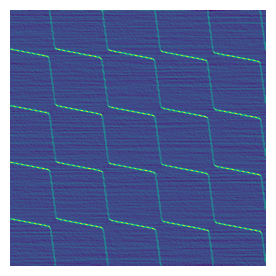

In [40]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.axis('off')
plt.tight_layout(pad=0)
plt.pcolormesh(csd_gradient[0,:,:,0])
plt.show()


SYSTEM CONFIGURATION
Config tuple: (6, 4, 2)
tunnel_coupling_const = 9.999999999999999e-05,
slow_noise_amplitude = 9.999999999999999e-06,
fast_noise_amplitude = 2.9999999999999997e-05
ks = nan, p_dd = 0.3, p_dg = 0.2
DEVICE
Sensors_coordinates:[[150.0, 0.0], [150.0, 4.71238898038469]]


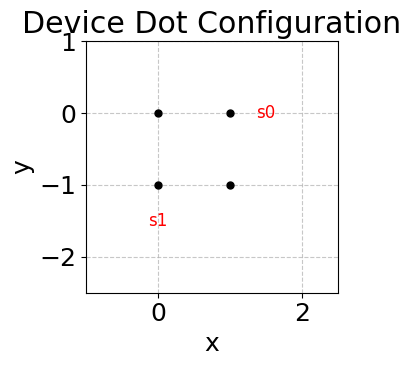

In [5]:
print("SYSTEM CONFIGURATION")
print(f"Config tuple: {config_tuple}")
print(f"tunnel_coupling_const = {tunnel_coupling_const},\nslow_noise_amplitude = {slow_noise_amplitude},\nfast_noise_amplitude = {fast_noise_amplitude}")
print(f"ks = {ks}, p_dd = {p_dd}, p_dg = {p_dg}")

print("DEVICE")
print(f"Sensors_coordinates:{sensors_coordinates.tolist()}")
%matplotlib inline
fig, ax = u.plot_device_lattice(device, sensors_coordinates)
plt.show()


In [6]:
print(f"C_DD:\n {C_DD}")
print(f"C_DG:\n {C_DG}")

for i, c in enumerate(cuts):
    print(f"Cut {i+1}: {c.tolist()}")


C_DD:
 [[ 32.3797   2.1358   1.9945   1.3658   4.3536   4.3536]
 [  2.1358  41.7841   1.2285   2.2807  14.7175   3.0665]
 [  1.9945   1.2285  38.7927   2.1299   2.8636  13.744 ]
 [  1.3658   2.2807   2.1299  39.7605   7.3635   7.3635]
 [  4.3536  14.7175   2.8636   7.3635 100.       7.7769]
 [  4.3536   3.0665  13.744    7.3635   7.7769 100.    ]]
C_DG:
 [[7.6331 1.4239 1.3297 0.7698 0.     0.    ]
 [1.4239 7.4981 0.6924 1.5205 0.     0.    ]
 [1.3297 0.6924 7.0936 1.4199 0.     0.    ]
 [0.7698 1.5205 1.4199 7.5419 0.     0.    ]
 [0.     0.     0.     0.     7.0938 0.    ]
 [0.     0.     0.     0.     0.     8.896 ]]
Cut 1: [[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]]
Cut 2: [[1, 0, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]]
Cut 3: [[1, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
Cut 4: [[0, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0]]
Cut 5: [[0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0]]
Cut 6: [[0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 0, 0]]


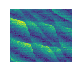

In [7]:
%matplotlib inline
fig, ax = u.plot_csd_from_sensor(sensor_output, cut=0, sensor_channel=0)
plt.show()

#####  Gradients

In [29]:
sensor_output.shape

(6, 96, 96, 2)

In [27]:
csd_gradient.shape


(6, 96, 96, 2)

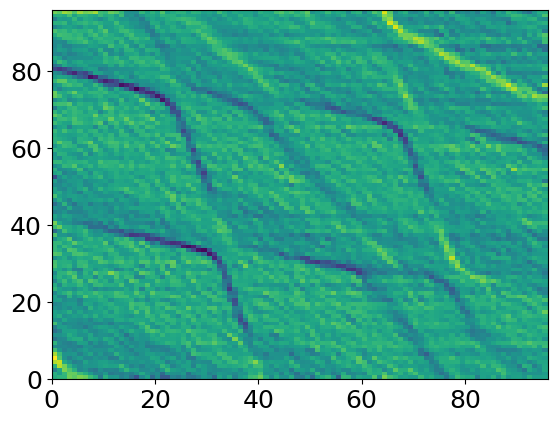

In [30]:
grad_c1 = np.gradient(sensor_output[0,:,:,0], axis=0) + np.gradient(sensor_output[0,:,:,0], axis=1)
plt.pcolormesh(grad_c1)

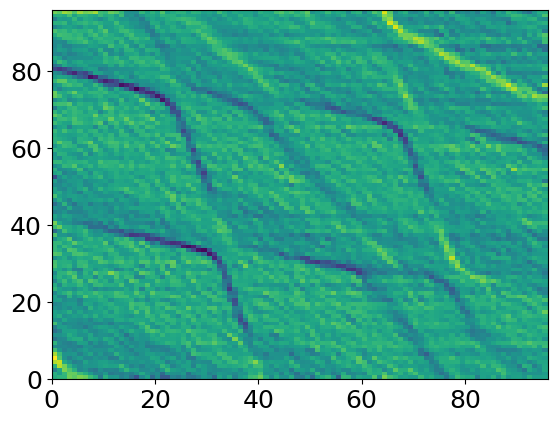

In [31]:
plt.pcolormesh(csd_gradient[0,:,:,0])

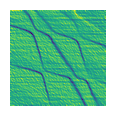

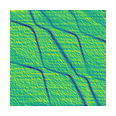

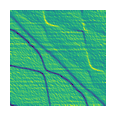

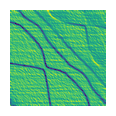

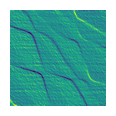

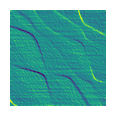

In [23]:
gradinetns_input = np.sum(csd_gradient, axis=3)


for i in range(len(gradinetns_input)):
    plt.figure(figsize=(0.96, 0.96), dpi=100)
    plt.pcolormesh(gradinetns_input[i])
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.savefig('datasets/pod_prezentacje/grad_'+str(i+1)+'.png', format='png',
                 bbox_inches='tight', pad_inches=0, dpi=100)


### Looking at the data

In [8]:
%matplotlib inline
if c.PATH_0 == './ALICE/':
    batch_number = 2
    img_number = '0035487789'
else:
    batch_number = 3
    img_number = '0060485230'

# 21 : 3990714507 , 4306286080 , 5016070997 , 4592798557 , 4870765773
# 22 : 9175617790 , 9043315088 , 8890086813 , 8532766679 , 9775337420 , 8118788830 , 5237945314
# u.reconstruct_img_with_matrices(batch_number, img_number, True)[0]
fig, c_dd, c_dg = u.reconstruct_img_with_matrices(23, '0049660032_01_s1.png', (6,4,2))
print(f"c_dd = {c_dd.tolist()}\nc_dg = {c_dg.tolist()}")
fig

The file path: ./ALICE/N-4_S-2\96x96\batch-23\datapoints.h5


KeyError: "Unable to synchronously open object (object '0049660032_01_s1.png.png' doesn't exist)"

In [7]:
parms_names = ['p_dg', 'p_dd', 'tunnel_coupling_const', 'slow_noise_amplitude', 
               'fast_noise_amplitude', 'sensors_coordinates', 'r_min', 'r_max']
params = u.load_parameters(3, '2868371462', [3,2,1], parms_names)
print(params)

{'p_dg': 0.3, 'p_dd': 0.65, 'tunnel_coupling_const': 1e-06, 'slow_noise_amplitude': 4.9999999999999996e-06, 'fast_noise_amplitude': 5e-08, 'sensors_coordinates': array([[1175.79898435,    5.43035221]]), 'r_min': 1000, 'r_max': 5000}


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Device Dot Configuration'}, xlabel='x', ylabel='y'>)

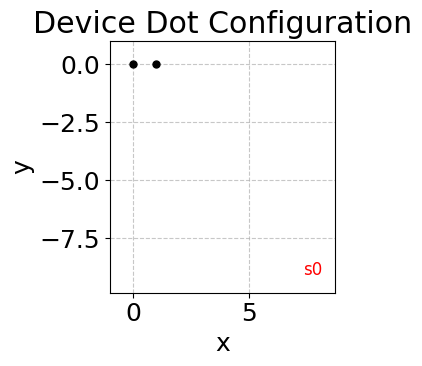

In [8]:
%matplotlib inline
# 19 : 6855079316 , 4269757637 , 0704002487
parms_names = ['device', 'sensors_coordinates']
params = u.load_parameters(3, '2868371462', [3,2,1], parms_names)
u.plot_device_lattice(params['device'], params['sensors_coordinates'])


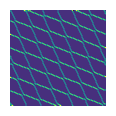

In [2]:
grad = u.load_parameters(1, '0005722789', [3,2,1], ['csd_gradient'])

csd = u.load_parameters(1, '0005722789', [3,2,1], ['csd'])


%matplotlib inline
fig, ax = plt.subplots(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
ax.pcolormesh(grad['csd_gradient'].squeeze())
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# mu.show_image_from_tensor(csd['csd'])


Loading batches: 1 from ./ALICE/N-2_S-1\96x96\batch-1\datapoints.h5
Original dataset size: 1000
Filtered dataset size: 998
Removed 2 datapoints
Preprocessing data...
Data preprocessed.
Loading batches: 1 from ./ALICE/N-2_S-1\96x96\batch-1\datapoints.h5
Original dataset size: 1000
Filtered dataset size: 998
Removed 2 datapoints
Preprocessing data...
Data preprocessed.


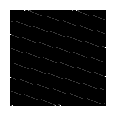

In [3]:
config_tuple = (3,2,1)
X, y = mu.prepare_data(config_tuple, all_batches=False, batches=np.arange(1,2), param_names=['csd_gradient', 'C_DD', 'C_DG'])
X_1, y_1 = mu.prepare_data(config_tuple, all_batches=False, batches=np.arange(1,2), param_names=['csd', 'C_DD', 'C_DG'])
%matplotlib inline
mu.show_image_from_tensor(X[0])

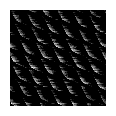

In [4]:
mu.show_image_from_tensor(X_1[0])

### Data preprocessing

In [10]:
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
datapoints_gradient = mu.load_datapoints((3,2,1),param_names=['csd','csd_gradient', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))
datapoints = mu.load_datapoints((2,2,0),param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

print(f"The amount of datapoints loaded: {len(datapoints_gradient)}.")
print(f"The shape of CSD gradient {datapoints_gradient[0][0].shape}, and its type {type(datapoints_gradient[0][0])}.")


Loading batches: 1 from ./datasets/N-2_S-1\96x96\batch-2\datapoints.h5
Loading batches: 1 from ./datasets/K-2\96x96\batch-2\datapoints.h5
The amount of datapoints loaded: 500.
The shape of CSD (4, 96, 96), and its type <class 'numpy.ndarray'>.
The amount of datapoints loaded: 50.
The shape of CSD gradient (4, 96, 96), and its type <class 'numpy.ndarray'>.


#### Reconstructed image from saved np.ndarray

In [11]:
example = datapoints[19] # 67, 19
example_gradient = datapoints_gradient[19] # 67, 19

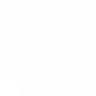

In [12]:
example_csd = example[0]
example_csd_noisy = example_gradient[0]
example_csd_gradient = example_gradient[1]

example_csd.shape
%matplotlib inline
u.reconstruct_img_from_tensor(example_csd)

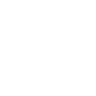

In [13]:
%matplotlib inline
u.reconstruct_img_from_tensor(example_csd_noisy)

In [14]:
u.reconstruct_img_from_tensor(example_csd_gradient)

TypeError: Cannot handle this data type: (1, 1, 1), |u1

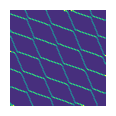

In [10]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(example_csd_gradient[0])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

#### The preprocessed input seen by the model

In [6]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

TypeError: CSD image must be of a shape 4x96x96

#### Output preproccess

In [ ]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

In [ ]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

#### Filter dataset

In [ ]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

#### Train model

### Unit tests

In [15]:
c_dd, c_dg = u.generate_capacitance_matrices()
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
c_dd_rec, c_dg_rec = mu.reconstruct_capacitance_matrices(output)

assert (c_dd == c_dd_rec).all() and (c_dg == c_dg_rec).all()

In [16]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)outputmupepocess_cpacitance_matricesc_ddc_dg
# c_m = 0.5
# c_dd = np.array([[3.1, 0.5], [0.5, 2.9]])
# np.sum(c_dg, axis=1).T*np.eye(c.K)+c_m

c_dd, c_dg = u.generate_capacitance_matrices()
c_m =  c_dd[0,1]

c_dd_test = np.array([[c_dg[0,0]+c_dg[0,1]+c_m, c_m], [c_m, c_dg[1,0]+c_dg[1,1]+c_m]])

if c.K == 2:
    assert (c_dd == c_dd_test).all()
    assert c_dd[0,1] == c_dd[1,0]

### XAI

In [3]:
path_pred =  './Results/resnet12/resnet12_model_20241204_202509/predictions.h5'
name = './'

try:
    with h5py.File(path_pred, 'r') as f:
        main_group = f[name]
        print_group_structure(main_group)

        inputs = f[f"{name}/inputs"][()]
        outputs = f[f"{name}/outputs"][()]
        targets = f[f"{name}/targets"][()]      

except Exception as e:
    print(f"Error: {e}")

print(f"Type: {type(inputs)}, type inside: {type(inputs[0])}, shape: {inputs.shape}")
print(f"Type: {type(outputs)}, shape: {outputs.shape}")
print(f"Type: {type(targets)}, shape: {targets.shape}")

preds = [(inputs[i], outputs[i], targets[i], np.linalg.norm(targets[i]-outputs[i])) for i in range(len(inputs))]

├── inputs
  └── Shape: (10000, 1, 96, 96), Type: float32
├── outputs
  └── Shape: (10000, 7), Type: float32
├── targets
  └── Shape: (10000, 7), Type: float32
Type: <class 'numpy.ndarray'>, type inside: <class 'numpy.ndarray'>, shape: (10000, 1, 96, 96)
Type: <class 'numpy.ndarray'>, shape: (10000, 7)
Type: <class 'numpy.ndarray'>, shape: (10000, 7)


In [4]:
sorted_preds = sorted(preds, key=lambda x: x[-1])

i=0
j=-1
best_tensor = mu.preprocess_csd(sorted_preds[i][0], 'csd').reshape((1,1,96,96))
worst_tensor = mu.preprocess_csd(sorted_preds[j][0], 'csd').reshape((1,1,96,96))

print(type(best_tensor), best_tensor.shape)
print(f"Best:{sorted_preds[i][-1]}")
print(f"Worst:{sorted_preds[j][-1]}")


best_tensor = best_tensor

print(f"Best Abs: {np.round(np.abs(sorted_preds[0][1]-sorted_preds[0][2]).tolist(), 5)}")
print(f"Worst Abs: {np.round(np.abs(sorted_preds[-1][1]-sorted_preds[-1][2]).tolist(), 5)}")


<class 'torch.Tensor'> torch.Size([1, 1, 96, 96])
Best:0.02534852735698223
Worst:2.5339531898498535
Best Abs: [0.0097  0.00902 0.01355 0.00904 0.00511 0.00615 0.01174]
Worst Abs: [0.36805 0.33243 1.66969 0.01609 0.03914 0.18858 1.83022]


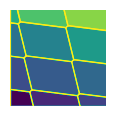

In [22]:
plt.figure(figsize=(0.96, 0.96), dpi=100)
plt.imshow(sorted_preds[0][0][0,:,:], )
plt.axis('off')
plt.tight_layout(pad=0)
plt.savefig("datasets/pod_prezentacje/true_best.png", format='png',
                 bbox_inches='tight', pad_inches=0, dpi=100)


In [44]:
saliency_overlay, gradcam_overlay, prediction, reconstructed_matrices= mu.explain_output(
    config_tuple=(2,2,0),
    input_tensor=best_tensor,
    model_name='resnet12',
    model_path='./Results/resnet12/resnet12_model_20241204_202509/resnet12_model.pth')

print(f"Target:\n {mu.reconstruct_capacitance_matrices(config_tuple=(2,2,0), output=sorted_preds[0][2])}")
print(f"Prediction:\n {reconstructed_matrices}")

Using custom ResNet with 12 layers. No pretrained weights used in the model.
Type of input tensor: <class 'torch.Tensor'>, shape: torch.Size([1, 1, 96, 96])
Target:
 (array([[ 8.87990093,  1.21236062],
       [ 1.21236062, 11.11353683]]), array([[6.554399 , 1.1131417],
       [0.7321908, 9.168985 ]], dtype=float32))
Prediction:
 (array([[ 8.87020111,  1.20334125],
       [ 1.20334125, 11.1270895 ]]), array([[6.5453563, 1.1182511],
       [0.7383378, 9.180721 ]], dtype=float32))


d:\!!!_PDF\Fizyka i matma studia\!!!_Leiden\!! projekty 2024_25\Evert van Niewenburg\potencial projects\Qdarts projects\qdarts_code\learning_parameters\utilities\model_utils.py:971: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub 

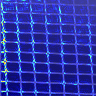

In [32]:
saliency_overlay

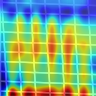

In [33]:
gradcam_overlay

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[23.46443558  0.83419228]
 [ 0.83419228 33.08411407]]
                Dot-gate capacitances: 
                [[21.431473   1.1987703]
 [ 1.0572915 31.192629 ]]
                Size of Coulomb peaks V[n] is constant
                


C:\Users\barte\AppData\Local\Temp\ipykernel_54716\1565051147.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


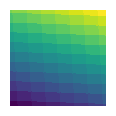

In [35]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(config_tuple=(2,2,0), prediction=sorted_preds[-1][2])
plot.show()
plt.savefig("datasets/pod_prezentacje/true_best.png", format='png',
                 bbox_inches='tight', pad_inches=0, dpi=100)


EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[23.83248711  1.1666255 ]
 [ 1.1666255  31.41441917]]
                Dot-gate capacitances: 
                [[21.415386   1.2379065]
 [ 0.8687085 29.362406 ]]
                Size of Coulomb peaks V[n] is constant
                


C:\Users\barte\AppData\Local\Temp\ipykernel_54716\1800375677.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plot.show()


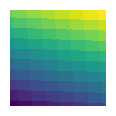

In [36]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(config_tuple=(2,2,0), prediction=prediction)
plot.show()
plt.savefig("datasets/pod_prezentacje/pred_best.png", format='png',
                 bbox_inches='tight', pad_inches=0, dpi=100)

In [16]:
C_DD = np.ones((6,6))
S = 2
# C_DD = np.fill_diagonal(C_DD[-S:, -S:], 100)
# C_DD[np.diag(C_DD)[-S:]] = [100]*S



C_DD

array([[  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1.,   1.,   1.],
       [  1.,   1.,   1.,   1., 100.,   1.],
       [  1.,   1.,   1.,   1.,   1., 100.]])

In [ ]:
u.exp_decay_model()

### Noise - test

In [2]:
print(f"Noise amplitudes:\n - Fast: {c.fast_noise_amplitude}\n - Slow: {c.slow_noise_amplitude}")
print(f"Normal distributions:\n [*] dot-to-dot: mean = {c.dd_avg}, std = {c.dd_std}\n [*] dot-to-gate: mean = {c.dg_avg}, std = {c.dg_std}")

Noise amplitudes:
 - Fast: 1e-99
 - Slow: 1e-99
Normal distributions:
 [*] dot-to-dot: mean = 25.0, std = 5.0
 [*] dot-to-gate: mean = 15.0, std = 2.0


In [3]:
x_vol = np.linspace(-0.01, 0.05, c.RESOLUTION)
y_vol = np.linspace(-0.01, 0.05, c.RESOLUTION)
ks = 0

# device = np.array([[1,1],[1,1]])

S = 1
K = 3
device = np.ones((1,2), dtype=int) if S>0 else None
N = len(u.get_dots_indices(device)) if device is not None else K
config_tuple = (K,N,S)

cut = np.array([[1,0,0], [0,1,0]])
sensors_angle = [0]
sensors_radius = [2*c.d_DD]
    
r = u.generate_dataset(x_vol, y_vol, ks, device, 
                       config_tuple,
                       sensors_angle=sensors_angle, 
                       sensors_radius=sensors_radius, 
                       all_euclidean_cuts=False)

C_DD, C_DG, ks, cuts, x, y, csd, poly, sensor, device, sensors_coordinates = r

if S>1:
    figs = [fig for fig, _ in u.plot_CSD(x, y, sensor, poly)]
    gradients = [np.gradient(s,axis=0)+np.gradient(s,axis=1) for s in sensor]


Generating dataset for (3, 2, 1) configuration
EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[  0.         5.718921   1.097998]
 [  5.718921   0.         5.033416]
 [  1.097998   5.033416 100.      ]]
                Dot-gate capacitances: 
                [[1.5361175e+01 7.6019000e-02 0.0000000e+00]
 [1.9420000e-03 1.8135646e+01 0.0000000e+00]
 [0.0000000e+00 0.0000000e+00 1.2150181e+01]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [2]
            Sensor detunings: [0.5] meV
            Coulomb peak width: 0.82 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 

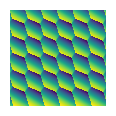

In [10]:
%matplotlib inline
figs_and_ax = u.plot_CSD(x, y, sensor, poly) 

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

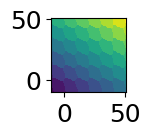

In [11]:
%matplotlib inline
figs_and_ax = u.plot_CSD(x, y, csd.squeeze(), poly) 

In [5]:
u.create_paths(config_tuple)
u.save_datapoints(config_tuple, C_DD, C_DG, ks, x_vol, y_vol, cuts, poly, csd,
                 sensor, figs, gradients, device, sensors_coordinates)

Created directory: ./ALICE/N-4_S-2\96x96\batch-24
Created directory: ./ALICE/N-4_S-2\96x96\batch-24\imgs
Created directory: ./ALICE/N-4_S-2\96x96\batch-24\imgs\6406814489


In [ ]:
# %matplotlib inline
# import matplotlib.pyplot as plt

# data = sensor[0,:,:,1]
# fig = plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
# plt.imshow(data)
# plt.axis('off')
# plt.tight_layout(pad=0)
                    
# plt.savefig('test_plot_1.png', format='png', bbox_inches='tight', 
#                             pad_inches=0, dpi=c.DPI)

# fig = plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
# plt.pcolormesh(data)
# plt.axis('off')
# plt.tight_layout(pad=0)
                    
# plt.savefig('test_plot_2.png', format='png', bbox_inches='tight', 
#                             pad_inches=0, dpi=c.DPI)


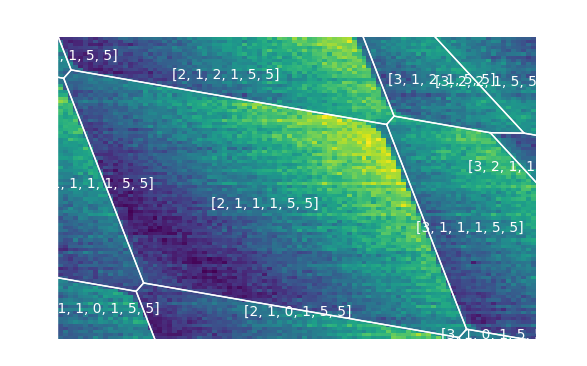

In [17]:
plt.figure(figsize=(6, 4), dpi=100)
ax = plt.gca()
plt.axis('off')       
plt.tight_layout()
ax.pcolormesh(1e3*x, 1e3*y, sensor[1,:,:,0].squeeze())

plot_polytopes(ax, poly[1], axes_rescale=1e3, 
               only_edges=False, only_labels=False)

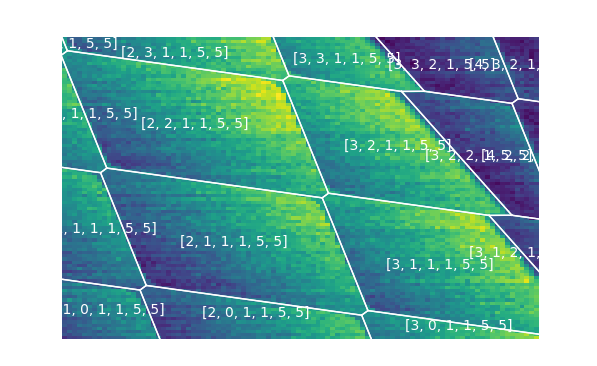

In [15]:
plt.figure(figsize=(6, 4), dpi=100)
ax = plt.gca()
plt.axis('off')       
plt.tight_layout()
ax.pcolormesh(1e3*x, 1e3*y, sensor[0,:,:,1].squeeze())

plot_polytopes(ax, poly[0], axes_rescale=1e3, 
                            only_edges=False, only_labels=False)

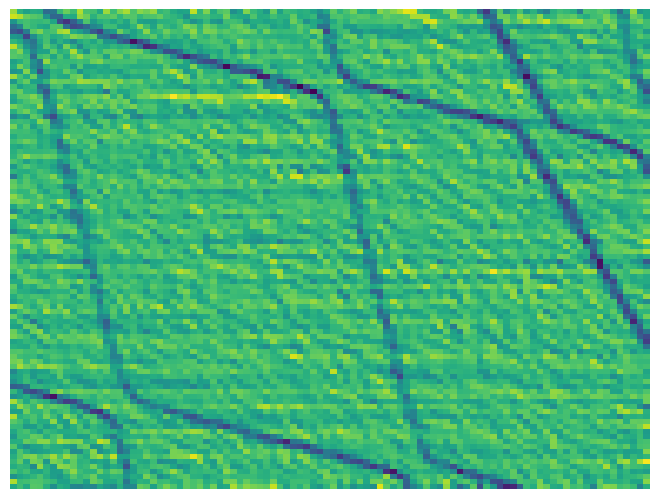

In [5]:
grad = np.gradient(sensor[0,:,:,0], axis=0)+np.gradient(sensor[0,:,:,0], axis=1) + np.gradient(sensor[0,:,:,1], axis=0) + np.gradient(sensor[0,:,:,1], axis=1)


plt.pcolormesh(grad)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

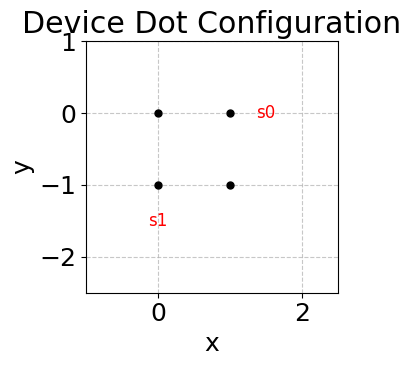

In [6]:
fig, ax = u.plot_device_lattice(device, sensors)

In [14]:
assert np.all(np.sum([np.gradient(sensor, axis=i) for i in [0,1]], axis=0) == np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))

In [6]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
# csd_grad =
plt.pcolormesh( np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
print(csd_grad.shape)

csd_grad_toech = torch.from_numpy(csd_grad).permute(2, 0, 1).float() / 255.0

SyntaxError: invalid syntax (2561031521.py, line 3)

In [93]:
len(np.array([ [[1,2],[1,2]], [[1,9],[6,9]] ]).shape)

3

### File reading

In [11]:
path = 'Results/resnet10/resnet10_model_20241203_104554/predictions.h5'
config_tuple = (3,2,1)

def print_structure_h5_file(name, obj):
    """Helper function to print HDF5 file structure"""
    print(name)
    if isinstance(obj, h5py.Dataset):
        print(f"    Shape: {obj.shape}")
        print(f"    Type: {obj.dtype}")


with h5py.File(path, 'r') as f:
    f.visititems(print_structure_h5_file)
    inputs = f['inputs'][()][:2]
    outputs = f['outputs'][()][:2]
    targets = f['targets'][()][:2]



vals = []
l2_vals = []
for output, target in zip(outputs, targets):
    vals.append((output, target, mu.physics_informed_regularization(config_tuple, output, target), np.linalg.norm(output-target)))

for output, target in zip(outputs, targets):
    l2_vals.append(np.linalg.norm(output-target))

for v in vals:
    print(v)

# print(f"L2 norm values: mean={np.mean(l2_vals)}, min={min(l2_vals)}, max={max(l2_vals)}")

# mean_vals = np.mean([x[2] for x in vals])
# min_vals = min(vals, key=lambda x: x[-1])
# max_vals = max(vals, key=lambda x: x[-1])

# print(f"PI reg.: mean={mean_vals},\n min={min_vals} ({np.linalg.norm(min_vals[0]-min_vals[1])}),\n max={max_vals} ({np.linalg.norm(max_vals[0]-max_vals[1])})")


inputs
    Shape: (10000, 1, 96, 96)
    Type: float32
outputs
    Shape: (10000, 15)
    Type: float32
targets
    Shape: (10000, 15)
    Type: float32
(array([2.3036381e+01, 4.6295619e+00, 2.6039811e-02, 2.1029575e+01,
       1.3832517e-02, 1.5328026e+01, 7.5555553e+00, 2.1548426e+00,
       2.5120797e-03, 2.1548619e+00, 8.0061226e+00, 1.9179435e-03,
       2.0699285e-03, 4.6665827e-03, 7.6808863e+00], dtype=float32), array([2.38487e+01, 4.76650e+00, 1.13000e-02, 2.05665e+01, 7.20000e-03,
       2.20747e+01, 7.46400e+00, 2.19990e+00, 0.00000e+00, 2.19990e+00,
       7.87660e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.06074e+01],
      dtype=float32), 15.612511496046595, 7.416512)
(array([6.0400963e+01, 1.4342017e+01, 6.1852127e-02, 6.7824623e+01,
       2.8620267e-02, 4.3115639e+01, 1.8118141e+01, 6.7006359e+00,
       1.5409231e-02, 6.6991992e+00, 2.2903978e+01, 1.9646420e-03,
       4.5102262e-03, 6.0284231e-03, 2.2083418e+01], dtype=float32), array([6.35879e+01, 1.64815e+01, 2.3

In [12]:
outputs = torch.tensor(outputs)
targets = torch.tensor(targets)

mu.physics_informed_regularization_torch(config_tuple, outputs, targets)

tensor([464.1948,  61.8283])

### Maxwell capacitance matrix

In [4]:
# device = np.ones((1,2))
device = np.array([[1,1],[1,0]])

N_y, N_x = device.shape
# device = np.array([[1,1,0,0,1]])

sensors_radius = [(N_x-0.5)*c.d_DD, (N_y-0.5)*c.d_DD]
sensors_angle = [0, 3/2*np.pi]
# sensors_radius = [1.5*c.d_DD]
# sensors_angle = [0]
S = len(sensors_angle)
N = len(u.get_dots_indices(device))
K = N+S

config_tuple = (K, N, S)
const_sensor_r = False

C_DD, C_DG, sensors_coordinates = u.generate_capacitance_matrices(config_tuple=config_tuple, 
                                             device=device, 
                                             sensors_angle=sensors_angle, 
                                             sensors_radius=sensors_radius)

print(device, sensors_coordinates)

[[1 1]
 [1 0]] [(150.0, 0), (150.0, 4.71238898038469)]


(<Figure size 400x400 with 1 Axes>,
 <Axes: title={'center': 'Device Dot Configuration'}, xlabel='x', ylabel='y'>)

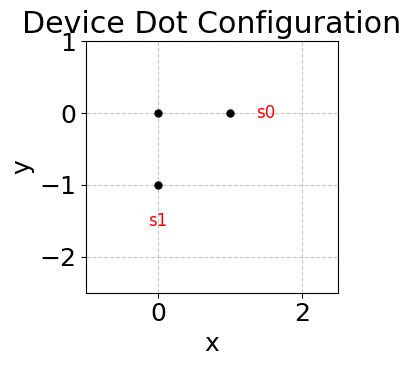

In [5]:
%matplotlib inline
u.plot_device_lattice(device, sensors_coordinates)

In [14]:
C_DD.tolist()

[[0.0, 9.748831, 2.14204],
 [9.748831, 0.0, 9.073896],
 [2.14204, 9.073896, 100.0]]

In [15]:
C_DG.tolist()

[[13.974714, 0.063951, 0.0], [0.019033, 14.67307, 0.0], [0.0, 0.0, 17.510253]]

In [16]:
maxwell_c_dd, maxwell_c_dg = u.get_maxwell_capacitance_matrices(C_DD, C_DG)
maxwell_c_dd.tolist()

[[25.929536, -9.748831, -2.14204],
 [-9.748831, 33.51483, -9.073896],
 [-2.14204, -9.073896, 128.726189]]

In [17]:
maxwell_c_dg.tolist()

[[13.974714, 0.063951, 0.0], [0.019033, 14.67307, 0.0], [0.0, 0.0, 17.510253]]

## Plot and eval results

In [2]:
import utilities.model_utils as mu
import utilities.utils as u
import numpy as np
import matplotlib.pyplot as plt

In [5]:
X,y = mu.prepare_data(config_tuple=(3,2,1),
                            param_names=['csd', 'C_DD', 'C_DG'], 
                            all_batches=False,
                            batches=np.arange(1,2), 
                            datasize_cut=5,
                            maxwell=True,
                            system_name='')

X_no, y_no = mu.prepare_data(config_tuple=(3,2,1),
                            param_names=['csd', 'C_DD', 'C_DG'], 
                            all_batches=False,
                            batches=np.arange(1,2), 
                            datasize_cut=5,
                            maxwell=True,
                            system_name='n5e5')


Loading data from ./ALICE/N-2_S-1\96x96\batch-1\datapoints.h5
Preprocessing data...
Data preprocessed. Using 1000 datapoints.
Loading data from ./ALICE/n5e5-N-2_S-1\96x96\batch-1\datapoints.h5
Preprocessing data...
Data preprocessed. Using 1000 datapoints.


In [4]:
# sensor_output = mu.load_datapoints(config_tuple=(3,2,1),
#                             param_names=['sensor_output'],
#                             all_batches=False,
#                             batches=np.arange(1,2), 
#                             system_name='n5e5')
# sensor_output = np.array(list(sensor_output.values())).squeeze()
# sensor_output.shape

Loading data from ./ALICE/n5e5-N-2_S-1\96x96\batch-1\datapoints.h5


(1000, 96, 96)

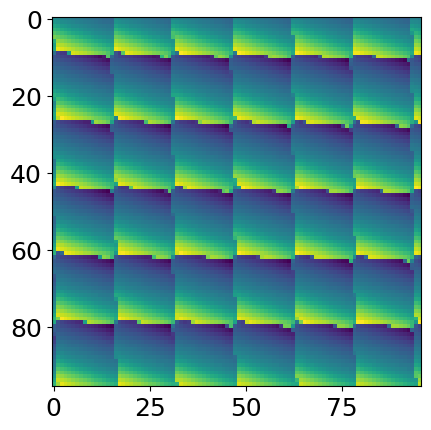

In [14]:
%matplotlib inline
plt.imshow(X[0,0], cmap='viridis')



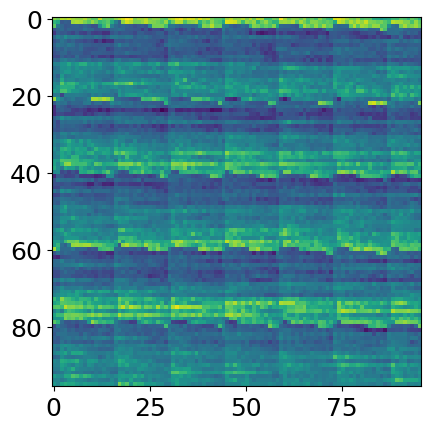

In [15]:
plt.imshow(X_no[0,0], cmap='viridis')

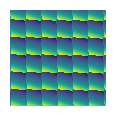

In [16]:
%matplotlib inline
mu.show_image_from_tensor(X[0], cmap='viridis')

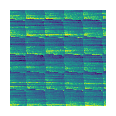

In [19]:
%matplotlib inline
mu.show_image_from_tensor(X_no[3], cmap='viridis')

In [10]:
X_g[0,0]

tensor([[[0.2078, 0.5176, 0.3882,  ..., 0.0471, 0.6863, 0.6667],
         [0.7686, 0.5059, 0.6275,  ..., 0.6549, 0.1451, 0.1412],
         [0.0196, 0.7490, 0.5765,  ..., 0.7765, 0.1176, 0.7843],
         ...,
         [0.6980, 0.7333, 0.2235,  ..., 0.2549, 0.4078, 0.2471],
         [0.5020, 0.0667, 0.7412,  ..., 0.5882, 0.4431, 0.0196],
         [0.0157, 0.1608, 0.9412,  ..., 0.2157, 0.0157, 0.4039]]])

In [ ]:
np.gradient(X_g[0,0], axis=0)+np.gradient(X_g[0,0], axis=1)+

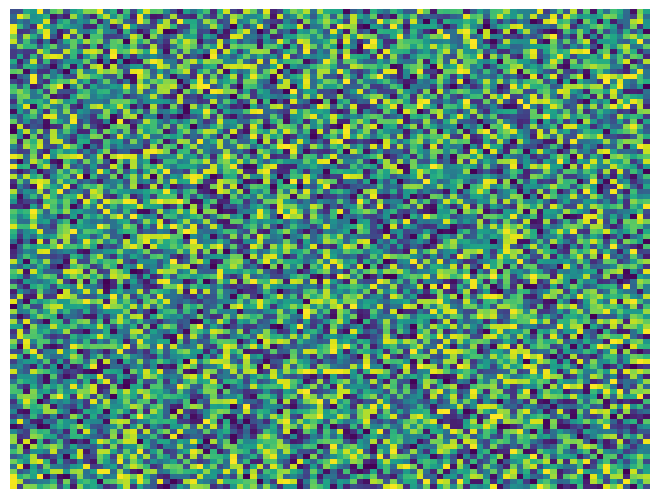

In [9]:
import matplotlib.pyplot as plt
# grad = np.gradient(sensor[0,:,:,0], axis=0)+np.gradient(sensor[0,:,:,0], axis=1) + np.gradient(sensor[0,:,:,1], axis=0) + np.gradient(sensor[0,:,:,1], axis=1)

plt.pcolormesh(X_g[0,1,0])
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()